In [25]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [26]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/user/git/TransportNet/Stable Dynamic & Beckman/model.py'>

In [27]:
import numba
numba.__version__

'0.59.1'

In [28]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/home/user/miniconda3/envs/venv/bin/python
3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
python 3.12.3
numpy 1.26.4
pandas 2.2.2
graph_tool 2.65 (commit bd697989, )


# Stable Dynamics Model

parameter $\mu = 0$

In [29]:
sd_save = 'stable_dynamics_results/'
cities_data = 'cities_data/'
net_name = cities_data + 'Anaheim_net.tntp'
trips_name = cities_data + 'Anaheim_trips.tntp'

In [30]:
handler = dh.DataHandler()
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
init_capacities = np.copy(graph_data['graph_table']['capacity']) * 2.5

## Base flows
First of all, we should find admissible set of flows on the transport graph. It is required for defining duality gap.

In [31]:
alpha = 0.75
graph_data['graph_table']['capacity'] = init_capacities * alpha
model = md.Model(graph_data, graph_correspondences,
                 total_od_flow, mu = 0)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,16875.0,1.090458
1,2,False,87,True,16875.0,1.090458
2,3,False,74,True,16875.0,1.090458
3,4,False,233,True,16875.0,1.090458
4,5,False,165,True,16875.0,1.090458


In [32]:
assert(model.mu == 0)
max_iter = 1000

solver_kwargs = {'eps': 1e-4,
                 'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 200, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'ustm', composite = True,
                                solver_kwargs = solver_kwargs,
                                base_flows = alpha * graph_data['graph_table']['capacity'])
                                #base_flows here doesnt define anything now
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic

base_flows = result['flows']

Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 3.1934e+06

Iterations number: 200
Inner iterations number: 391
Primal_func_value = 1.24959e+06
Dual_func_value = -1.2634e+06
Duality_gap = 136620
Duality_gap / Duality_gap_init = 0.0427819

Iterations number: 400
Inner iterations number: 793
Primal_func_value = 1.24958e+06
Dual_func_value = -1.315e+06
Duality_gap = 85015.4
Duality_gap / Duality_gap_init = 0.0266222

Iterations number: 600
Inner iterations number: 1189
Primal_func_value = 1.24959e+06
Dual_func_value = -1.51271e+06
Duality_gap = -112692
Duality_gap / Duality_gap_init = -0.0352891

Iterations number: 800
Inner iterations number: 1589
Primal_func_value = 1.24959e+06
Dual_func_value = -1.96109e+06
Duality_gap = -561060
Duality_gap / Duality_gap_init = -0.175693

Iterations number: 1000
Inner iterations number: 1996
Primal_func_value = 1.24958e+06
Dual_func_value = -2.19885

In [33]:
with open(sd_save + 'anaheim_' + 'ustm' + '_base_flows_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
   pickle.dump(base_flows, f)

## Модель

In [34]:
with open(sd_save + 'anaheim_' + 'ustm' + '_base_flows_max_iter_' + str(1000) + '_SD.pickle', 'rb') as f:
    base_flows = pickle.load(f)

In [35]:
epsilons = np.logspace(2,0,9)
epsilons

array([100.        ,  56.23413252,  31.6227766 ,  17.7827941 ,
        10.        ,   5.62341325,   3.16227766,   1.77827941,
         1.        ])

In [36]:
graph_data['graph_table']['capacity'] = init_capacities
model = md.Model(graph_data, graph_correspondences,
                 total_od_flow, mu = 0)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,22500.0,1.090458
1,2,False,87,True,22500.0,1.090458
2,3,False,74,True,22500.0,1.090458
3,4,False,233,True,22500.0,1.090458
4,5,False,165,True,22500.0,1.090458


## Universal Similar Triangles

In [37]:
assert(model.mu == 0)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose': True, 'verbose_step': 2000, 'save_history': True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustm', composite = True,
                                    solver_kwargs = solver_kwargs, base_flows = base_flows)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(sd_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(index) + '_SD.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 100.0
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Result: success
Total iters: 12
Primal_func_value = 1.24815e+06
Dual_func_value = -1.24822e+06
Duality_gap = 74.4369
Duality_gap / Duality_gap_init = 0.256635
Oracle elapsed time: 0 sec
Elapsed time: 0 sec
Time ratio = 2.375977664380495
Flow excess = 0.02591664794114701

eps_abs = 56.23413251903491
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Result: success
Total iters: 13
Primal_func_value = 1.2482e+06
Dual_func_value = -1.24822e+06
Duality_gap = 33.5391
Duality_gap / Duality_gap_init = 0.115632
Oracle elapsed time: 0 sec
Elapsed time: 0 sec
Time ratio = 2.2284658608943966
Flow excess = 0.008417261433127488

eps_abs = 31.622776601683793
Composite optimization...
Oracles created...
Universal simil

In [38]:
#index += 9
#epsilons = [300, 200]

## Universal Gradient Descent

In [39]:
#weighted t added
assert(model.mu == 0)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose': True, 'verbose_step': 2000, 'save_history': True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', composite = True,
                                    solver_kwargs = solver_kwargs, base_flows = base_flows)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(sd_save + 'anaheim_result_' + 'ugd' + '_eps_abs_' + str(index) + '_SD.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 100.0
Composite optimization...
Oracles created...
Universal gradient descent method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Result: success
Total iters: 13
Primal_func_value = 1.24815e+06
Dual_func_value = -1.24822e+06
Duality_gap = 66.7422
Duality_gap / Duality_gap_init = 0.230106
Oracle elapsed time: 0 sec
Elapsed time: 0 sec
Time ratio = 2.2966935738764516
Flow excess = 0.024609465673706588

eps_abs = 56.23413251903491
Composite optimization...
Oracles created...
Universal gradient descent method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Result: success
Total iters: 16
Primal_func_value = 1.24819e+06
Dual_func_value = -1.24821e+06
Duality_gap = 47.6771
Duality_gap / Duality_gap_init = 0.164375
Oracle elapsed time: 0 sec
Elapsed time: 1 sec
Time ratio = 2.1329871312054576
Flow excess = 0.013117561393799493

eps_abs = 31.622776601683793
Composite optimization...
Oracles created...
Universal grad

In [40]:
#index += 9
#epsilons = [300, 200]

## Weighted Dual Averages

### Composite optimization

In [41]:
assert(model.mu == 0)
max_iter = 50000
solver_kwargs = {'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = True, 
                                solver_kwargs = solver_kwargs, base_flows = base_flows)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(sd_save + 'anaheim_result_' + 'wda' + '_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
    pickle.dump(result, f)

Composite optimization...
Oracles created...
Weighted dual averages method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Iterations number: 4000
Primal_func_value = 1.2482e+06
Dual_func_value = -1.24822e+06
Duality_gap = 20.728
Duality_gap / Duality_gap_init = 0.0714636

Iterations number: 8000
Primal_func_value = 1.2482e+06
Dual_func_value = -1.24822e+06
Duality_gap = 14.3112
Duality_gap / Duality_gap_init = 0.0493405

Iterations number: 12000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 11.5552
Duality_gap / Duality_gap_init = 0.0398386

Iterations number: 16000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 9.9455
Duality_gap / Duality_gap_init = 0.0342889

Iterations number: 20000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 8.85475
Duality_gap / Duality_gap_init = 0.0305284

Iterations number: 24000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24

### Non-composite optimization

In [42]:
assert(model.mu == 0)
max_iter = 50000
solver_kwargs = {'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = False, 
                                solver_kwargs = solver_kwargs, base_flows = base_flows)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(sd_save + 'anaheim_result_' + 'wda_noncomposite' + '_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
    pickle.dump(result, f)

Non-composite optimization...
Oracles created...
Weighted dual averages method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Iterations number: 4000
Primal_func_value = 1.24816e+06
Dual_func_value = -1.24819e+06
Duality_gap = 84.9128
Duality_gap / Duality_gap_init = 0.292752

Iterations number: 8000
Primal_func_value = 1.24816e+06
Dual_func_value = -1.2482e+06
Duality_gap = 70.9427
Duality_gap / Duality_gap_init = 0.244588

Iterations number: 12000
Primal_func_value = 1.24817e+06
Dual_func_value = -1.24821e+06
Duality_gap = 55.6904
Duality_gap / Duality_gap_init = 0.192003

Iterations number: 16000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.24821e+06
Duality_gap = 47.0835
Duality_gap / Duality_gap_init = 0.162329

Iterations number: 20000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.24821e+06
Duality_gap = 41.4179
Duality_gap / Duality_gap_init = 0.142796

Iterations number: 24000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.

## Plots

In [43]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
import numpy as np
sd_save = 'stable_dynamics_results/'

In [44]:
"""
for method in ['ustm', 'ugd']:
    results = []
    i = 0
    while True:
        try:
            with open(sd_save + 'anaheim_result_' + method + '_eps_abs_'
                      + str(i) + '_SD.pickle', 'rb') as f:
                result = pickle.load(f)
                results.append(result) 
        except FileNotFoundError:
            break
        i += 1
    results.sort(key = lambda res : res['eps_abs'])
    
    for i, result in enumerate(results):
        with open(sd_save + 'anaheim_result_' + method + '_eps_abs_' 
                  + str(i) + '_SD.pickle', 'wb') as f:
            pickle.dump(result, f)
"""

"\nfor method in ['ustm', 'ugd']:\n    results = []\n    i = 0\n    while True:\n        try:\n            with open(sd_save + 'anaheim_result_' + method + '_eps_abs_'\n                      + str(i) + '_SD.pickle', 'rb') as f:\n                result = pickle.load(f)\n                results.append(result) \n        except FileNotFoundError:\n            break\n        i += 1\n    results.sort(key = lambda res : res['eps_abs'])\n    \n    for i, result in enumerate(results):\n        with open(sd_save + 'anaheim_result_' + method + '_eps_abs_' \n                  + str(i) + '_SD.pickle', 'wb') as f:\n            pickle.dump(result, f)\n"

In [45]:
results = {}

for method in ['ustm', 'ugd']:
    results[method] = {}
    results[method]['iters'] = []
    results[method]['inner_iters'] = []
    results[method]['epsilon'] = []
    results[method]['dual_gap_init'] = []
    i = 0
    while True:
        try:
            with open(sd_save + 'anaheim_result_' + method + '_eps_abs_'
                      + str(i) + '_SD.pickle', 'rb') as f:
                result = pickle.load(f)
                results[method]['epsilon'].append(result['eps_abs'])
                results[method]['iters'].append(result['iter_num'])
                results[method]['inner_iters'].append(result['history'].get('inner_iters')[-1])
                results[method]['dual_gap_init'].append(result['history'].get('dual_gap')[0])
        except FileNotFoundError:
            break
        i += 1

In [46]:
for method in ['wda', 'wda_noncomposite']:
    results[method] = {}
    with open(sd_save + 'anaheim_result_' + method + '_max_iter_50000_SD.pickle', 'rb') as f:
        result = pickle.load(f)
        results[method]['epsilon'] = result['history'].get('dual_gap')
        results[method]['iters'] = result['history'].get('iter')
        results[method]['dual_gap_init'] = result['history'].get('dual_gap')[0]

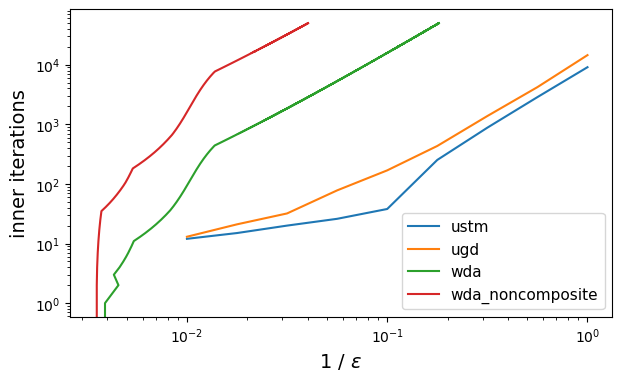

In [47]:
plt.figure(figsize=(7,4))
#plt.title('Convergence for Stable Dynamics model', fontsize=20)
for method, data in results.items():
    x = 1. / np.array(data['epsilon'])
    if 'inner_iters' in data:
        y = np.array(data['inner_iters'])
    else:
        y = np.array(data['iters'])
    plt.plot(x, y, label = method)
plt.legend(prop = {'size' : 11})
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\varepsilon$', fontsize = 14)
plt.ylabel('inner iterations', fontsize = 14)
#plt.savefig('SD_convergence_1.jpg', dpi = 300)
plt.show()

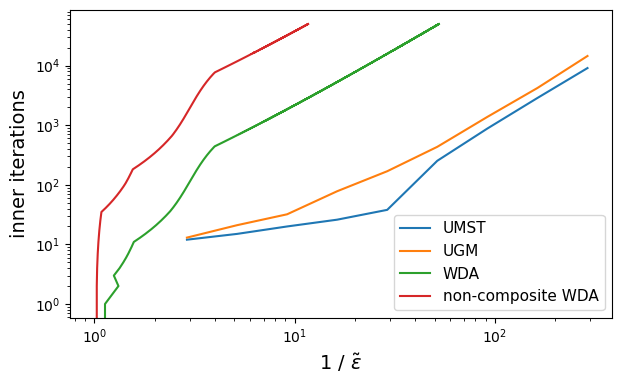

In [48]:
#inner iterations vs relative accuracy = eps_abs / dual_gap_init
plt.figure(figsize=(7,4))

method_names = {'ustm' : 'UMST', 'ugd' : 'UGM', 'wda' : 'WDA',
                'wda_noncomposite' : 'non-composite WDA'}
for method, data in results.items():
    x = 1. / (np.array(data['epsilon']) / np.array(data['dual_gap_init']))
    if 'inner_iters' in data:
        y = np.array(data['inner_iters'])
    else:
        y = np.array(data['iters'])
    plt.plot(x, y, label = method_names[method])
plt.legend(prop = {'size' : 11})
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\tilde\varepsilon$', fontsize = 14)
plt.ylabel('inner iterations', fontsize = 14)
#plt.savefig('sd_convergence_rel_eps.jpg', dpi = 300)
plt.show()